In [1]:
# Modules

import numpy as np
import scipy.integrate as spint
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
#import argparse

from dataclasses import dataclass
plt.rcParams['mathtext.fontset'] = 'stix'     


In [2]:
# Class for the CANN model

class cann_model:
    # define the range of perferred stimuli
    z_min = - np.pi;              
    z_range = 2.0 * np.pi;
    # define the time scale
    tau = 1.0
        
    # function for periodic boundary condition
    def dist(self, c):
        tmp = np.remainder(c, self.z_range)
        
        # routine for numbers
        if isinstance(tmp, (int, float)):
            if tmp > (0.5 * self.z_range):
                return (tmp - self.z_range);
            return tmp;
        
        # routine for numpy arraies
        for tmp_1 in np.nditer(tmp, op_flags=['readwrite']):
            if tmp_1 > (0.5 * self.z_range):
                tmp_1[...] = tmp_1 - self.z_range;
        
        return tmp;
    
    # constructor (?)
    def __init__(self, argument):
        self.k = argument.k;              # rescaled inhibition
        self.beta = argument.beta;        # rescaled STD
        self.beta_f = argument.beta_f;    # flat STD ?
        self.case = argument.case
        self.taud = argument.taud;        # rescaled STD timescale
        self.a = argument.a;              # range of excitatory connection
        self.b = argument.b;              # range of beta modulation
        self.N = argument.N;              # number of units / neurons
        self.dx = self.z_range / self.N     # separation between neurons

        self.rng = np.random.default_rng()
        
        # define perferred stimuli for each neuron
        self.x = (np.arange(0,self.N,1)+0.5) * self.dx + self.z_min;
        
        # difference of x's
        self.x_diff = np.array(
                       [[self.dist(self.x[i] - self.x[j]) 
                         for j in range(self.x.shape[0])]
                        for i in range(self.x.shape[0])]
                       )
        
        # calculate the excitatory couple for each pair of neurons
        self.Jxx = np.exp(-0.5 * np.square(
                      self.x_diff / self.a
                   ) ) / (np.sqrt(2*np.pi) * self.a);
                
        self.y = np.zeros((self.N + self.N * self.N));   # initialize dynamical variables
        self.y[self.N:] = 1.0
        
        
        
        if self.beta_f:
            self.beta = argument.beta
        else:
            self.beta = np.zeros_like(self.x_diff)
            
            for i in np.arange(self.Jxx.shape[1]):
                if self.case > 0:
                    gamma_randm = self.rng.gamma(shape=3.354520641938138, scale=9.743699331037247, size=self.Jxx.shape[0])
                else:
                    gamma_randm = self.rng.gamma(shape=1.377771974410986, scale=29.196273404252505, size=self.Jxx.shape[0])
                    #gamma_randm = np.random.gamma(shape=2.95, scale=(1.40*26.5)/2.95, size=self.Jxx.shape[0])
                    
                J_sort_idx = np.argsort(self.Jxx[:,i])
                gamma_sort_idx = np.argsort(gamma_randm)
                
                for j in np.arange(self.Jxx.shape[0]):
                    self.beta[J_sort_idx[j],i] = gamma_randm[gamma_sort_idx[j]]               
            
            
#            self.beta = 1.0 / (1.0 + np.exp(-np.square(self.x_diff/self.b)))
            self.beta *= argument.beta / np.mean(self.beta)
        
        
        # Here the first N y elements for u(x,t)
        # and the last N*N elements for p(x,x',t)
        
        self.r = np.zeros((self.N));                     # initialize neuronal activities
        self.input = np.zeros((self.N));                 # initialial the external input
    
    # function for setting external iput for each neuron
    def set_input(self, A, z0):
        self.input = \
        A * np.exp(-0.25 * np.square(self.dist(self.x - z0) / self.a));
    
    # function for calculation of neuronal activity of each neuron
    def cal_r_or_u(self, u_in):
        
        if (u_in.shape[0] > self.N):
            u = u_in[:self.N]
        else:
            u = u_in
            
        u0 = 0.5 * (u + np.abs(u));
        r = np.square(u0);
        B = 1.0 + 0.125 * self.k * np.sum(r) * self.dx \
        / (np.sqrt(2*np.pi) * self.a);
        r = r / B;
        
        return r;
    
    # Calculate the centre of mass of u(x,t)
    def cm_of_u(self):
        u = self.y[:self.N]
        max_i = u.argmax()
        cm = np.dot(self.dist(self.x - self.x[max_i]), u) / u.sum()
        cm = cm + self.x[max_i]
        return cm;
    
    # function for calculation of derivatives
    def get_dydt(self, t, y):
        u = y[:self.N]
        p = y[self.N:].reshape((self.N, self.N))
        r = self.cal_r_or_u(u)
        
        dudt = \
            -u + np.dot(self.Jxx* p , r) * self.dx + self.input;
        dudt = dudt / self.tau;
        
        dpdt = (1-p - self.beta * p * r ) / self.taud
        
        dydt = np.append(dudt, dpdt.reshape(-1))
        
        return dydt

In [3]:
# Defining a class of input arguments as a workaround 
# for the argparse

@dataclass()
class argument_c:
    k:float
    beta:float
    beta_f:bool
    case:int
    taud:float
    a:float
    b:float
    N:int
    
    def _init__(self, N, k, beta, beta_f, case, taud, a, b):
        self.N = N
        self.k = k
        self.beta = beta
        self.case = case
        self.beta_f = beta_f
        self.taud = taud
        self.a = a
        self.b = b

In [4]:
np.random.seed(100)

the_beta = 0.001

arg1 = argument_c(N=128, k=0.5, beta=the_beta, beta_f=False, case=0, taud=50, a=0.5, b=0.1)
the_model1 = cann_model(arg1)

arg2 = argument_c(N=128, k=0.5, beta=the_beta, beta_f=False, case=1, taud=50, a=0.5, b=100)
the_model2 = cann_model(arg2)

In [5]:
# Initialize the system

the_model1.set_input(0.5, 0)
the_model2.set_input(0.5, 0)
out1 = spint.solve_ivp(the_model1.get_dydt, (0, 1000), the_model1.y, method="RK45");
out2 = spint.solve_ivp(the_model2.get_dydt, (0, 1000), the_model2.y, method="RK45");

# update the network state in the CANN object
the_model1.y = out1.y[:,-1]
the_model2.y = out2.y[:,-1]

In [6]:

time_step = 2

# run the simulation and take snapshots every 10 taus
for t in range(0,100,time_step):
    # decide the period of this step
    t0 = t
    t1 = t + time_step
    # run the simulation and update the state in the CANN object
    out1 = spint.solve_ivp(the_model1.get_dydt, (t0, t1), the_model1.y, method="RK45")
    the_model1.y = out1.y[:,-1]
    out2 = spint.solve_ivp(the_model2.get_dydt, (t0, t1), the_model2.y, method="RK45")
    the_model2.y = out2.y[:,-1]
    

the_model1.set_input(0, 1.5)
the_model2.set_input(0, 1.5)

In [7]:
np.mean(the_model1.beta)

0.0010000000000000002

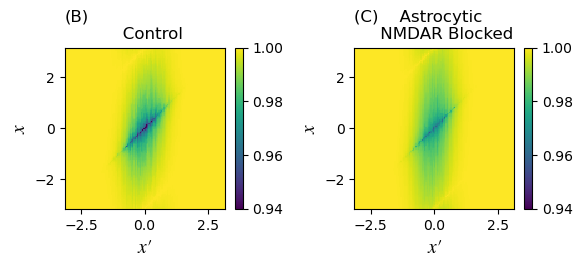

In [8]:
fig, ax = plt.subplots(1,2,figsize=(15/2.525, 7/2.525))

ax2 = ax[0]
ax3 = ax[1]


# plot2 = ax2.imshow(the_model1.y[the_model1.N:].reshape((the_model1.N, the_model1.N)).transpose(), 
#                extent=[-3.14, 3.14, -3.14, 3.14], vmin=0.94, vmax=1)
plot2 = ax2.pcolormesh(the_model1.x, the_model1.x, the_model1.y[the_model1.N:].reshape((the_model1.N, the_model1.N)), vmin=0.94, vmax=1)
ax2.set_xlabel(r"$x\prime$", fontsize=14)
ax2.set_ylabel(r"$x$", fontsize=14)
plt.colorbar(plot2, shrink=1)
ax2.set_title('(B)\n           Control', loc="left")

# plot3 = ax3.imshow(the_model2.y[the_model2.N:].reshape((the_model2.N, the_model2.N)).transpose(), 
#                extent=[-3.14, 3.14, -3.14, 3.14], vmin=0.94, vmax=1)
plot3 = ax3.pcolormesh(the_model2.x, the_model2.x, the_model2.y[the_model2.N:].reshape((the_model2.N, the_model2.N)), vmin=0.94, vmax=1)
ax3.set_xlabel(r"$x\prime$", fontsize=14)
ax3.set_ylabel(r"$x$", fontsize=14)
plt.colorbar(plot3, shrink=1)
ax3.set_title('(C)    Astrocytic\n     NMDAR Blocked', loc="left")

plt.tight_layout()

plt.savefig("Figure_2BC.pdf")

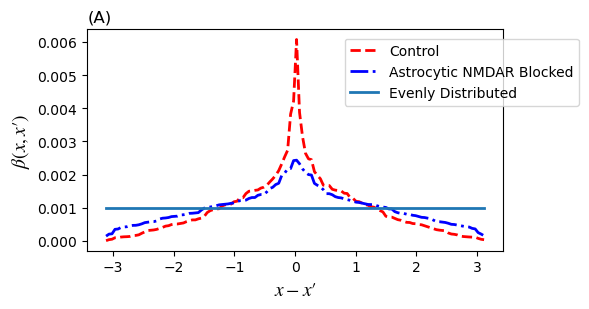

In [9]:
fig, ax = plt.subplots(1,1,figsize=(15/2.525, 7.5/2.525))

ax1 = ax

ax1.plot(the_model1.x, the_model1.beta[:,64], "r--", lw = 2, label="Control")
ax1.plot(the_model2.x, the_model2.beta[:,64], "b-.", lw = 2, label="Astrocytic NMDAR Blocked")
ax1.plot(the_model2.x, 0.001 * np.ones_like(the_model2.x), lw = 2, label="Evenly Distributed")
ax1.set_xlabel(r"$x-x\prime$", fontsize=14)
ax1.set_ylabel(r"$\beta (x,x\prime)$", fontsize=14)
ax1.legend(loc="upper right", bbox_to_anchor=(1.2, 0.99))
ax1.set_title(r"(A)", loc="left")

plt.subplots_adjust(left=0.15, right=0.85, top=0.92, bottom=0.175)

plt.savefig("Figure_2A.pdf")

In [10]:
the_model1.beta[50,:].mean()

0.0010134186970264013

In [11]:
the_model2.beta[50,:].mean()

0.0010017017510290196

In [12]:
the_model2.beta

array([[0.00305327, 0.00236785, 0.00242985, ..., 0.00222198, 0.00225962,
        0.00247989],
       [0.00276374, 0.00297171, 0.00260187, ..., 0.00205611, 0.00197659,
        0.00223435],
       [0.00217778, 0.00235349, 0.00263633, ..., 0.00197658, 0.00193156,
        0.00214314],
       ...,
       [0.00198821, 0.00193993, 0.00191996, ..., 0.00296125, 0.00226217,
        0.00239992],
       [0.00254113, 0.00202669, 0.00231213, ..., 0.00262465, 0.00259914,
        0.00252047],
       [0.00300815, 0.00207332, 0.00235529, ..., 0.00242975, 0.0022955 ,
        0.00265081]])